### 1. Start the Environment

In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='unity_envs/Reacher_Linux/Reacher_Linux.x86_64')

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [4]
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

* Set-up: A creature with 4 arms and 4 forearms.
* Goal: The agents must move its body toward the goal direction without falling.
* CrawlerStaticTarget - Goal direction is always forward.
* CrawlerDynamicTarget- Goal direction is randomized.
* Agents: The environment contains 3 agent linked to a single Brain.
* Agent Reward Function (independent):
* +0.03 times body velocity in the goal direction.
* +0.01 times body direction alignment with goal direction.
* Brains: One Brain with the following observation/action space.
* Vector Observation space: 117 variables corresponding to position, rotation, velocity, and angular velocities of each limb plus the acceleration and angular acceleration of the body.
* Vector Action space: (Continuous) Size of 20, corresponding to target rotations for joints.
* Visual Observations: None.
* Reset Parameters: None
* Benchmark Mean Reward for CrawlerStaticTarget: 2000
* Benchmark Mean Reward for CrawlerDynamicTarget: 400

Lets print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size[0]
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents) # initialize the score (for each agent)
step=0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    step+=1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.19199999570846557


### 4. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import random
import datetime
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


### 3. Define policy network (Actor Critic style)

In [8]:
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size
action_low = -1
action_high = 1

# define actor critic network
class ActorCritic(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(ActorCritic, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        self.std = nn.Parameter(torch.zeros(action_size))
        
        # common network
        self.fc1 = nn.Linear(state_size,512)
        
        # actor network
        self.fc2_actor = nn.Linear(512,256)
        self.fc3_action = nn.Linear(256,action_size)
        #self.fc3_std = nn.Linear(64,action_size)
        
        # critic network
        self.fc2_critic = nn.Linear(512,256)
        self.fc3_critic = nn.Linear(256,1)
    
    def forward(self,state):
        # common network
        x = F.relu(self.fc1(state))
        
        # actor network
        x_actor = F.relu(self.fc2_actor(x))
        action_mean = F.sigmoid(self.fc3_action(x_actor))
        ## rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        #action_std = F.sigmoid(self.fc3_std(x_actor))
        
        # critic network
        x_critic = F.relu(self.fc2_critic(x))
        v = self.fc3_critic(x_critic)
        return action_mean_,v
    
    def act(self,state,action=None):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,v = self.forward(state)
        prob_dist = Normal(action_mean,F.softplus(self.std))
        if action is None:
            action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action).sum(-1).unsqueeze(-1)
        entropy = prob_dist.entropy().sum(-1).unsqueeze(-1)
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'mean': action_mean,
                'v': v}

### 4. Storage class

In [9]:
class Storage:
    def __init__(self, size, keys=None):
        if keys is None:
            keys = []
        keys = keys + ['s', 'a', 'r', 'm',
                       'v', 'q', 'pi', 'log_pi', 'ent',
                       'adv', 'ret', 'q_a', 'log_pi_a',
                       'mean']
        self.keys = keys
        self.size = size
        self.reset()

    def add(self, data):
        for k, v in data.items():
            assert k in self.keys
            getattr(self, k).append(v)

    def placeholder(self):
        for k in self.keys:
            v = getattr(self, k)
            if len(v) == 0:
                setattr(self, k, [None] * self.size)

    def reset(self):
        for key in self.keys:
            setattr(self, key, [])

    def cat(self, keys):
        data = [getattr(self, k)[:self.size] for k in keys]
        return map(lambda x: torch.cat(x, dim=0), data)

### 4. PPO agent

In [27]:
from collections import deque
from itertools import accumulate
import torch.tensor as tensor

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]
        
class Agent:
    
    def __init__(self,env,learning_rate=1e-3):
        self.env = env
        nS = brain.vector_observation_space_size
        nA = brain.vector_action_space_size[0]
        self.policy = ActorCritic(state_size=nS,hidden_size=128,action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=learning_rate)
        
        # reset the environment
        env_info = self.env.reset(train_mode=True)[brain_name]
        self.states = env_info.vector_observations
        
        self.episode_rewards_window = deque(maxlen=100)
        self.episode_rewards = []
        num_trajectories = 20
        self.online_rewards = np.zeros(num_trajectories)
    
        
    def train(self,max_opt_steps=1000,num_trajectories=20,rollout_length=2048,mini_batch_size=64,gamma=.99,
              target_score=-250,use_gae=False,gae_tau=0.95,PRINT_EVERY=100):
        
        for opt_step in range(max_opt_steps):
        
            storage = Storage(rollout_length)
            
            for _ in range(rollout_length):
                prediction = self.policy.act(self.states)
                
                # send all actions to tne environment
                env_info = self.env.step((prediction['a']).cpu().numpy())[brain_name]
                
                next_states = np.array(env_info.vector_observations)         # get next state (for each agent)
                rewards = np.array(env_info.rewards)                      # get reward (for each agent)
                terminals = np.array(env_info.local_done)                  # see if episode finished
                
                self.online_rewards += rewards
                for i, terminal in enumerate(terminals):
                    if terminals[i]:
                        self.episode_rewards.append(self.online_rewards[i])
                        self.episode_rewards_window.append(self.online_rewards[i])
                        self.online_rewards[i] = 0
                
                storage.add(prediction)
                storage.add({'r': tensor(rewards).unsqueeze(-1).float().to(device),
                             'm': tensor(1 - terminals).unsqueeze(-1).float().to(device),
                             's': tensor(self.states).to(device)})
                self.states = next_states

            prediction = self.policy.act(self.states)
            storage.add(prediction)
            storage.placeholder()

            advantages = tensor(np.zeros((num_trajectories, 1))).float().to(device)
            returns = prediction['v'].detach()
            for i in reversed(range(rollout_length)):
                returns = storage.r[i] + gamma * storage.m[i] * returns
                if not use_gae:
                    advantages = returns - storage.v[i].detach()
                else:
                    td_error = storage.r[i] + gamma * storage.m[i] * storage.v[i + 1] - storage.v[i]
                    advantages = advantages * gae_tau * gamma * storage.m[i] + td_error
                storage.adv[i] = advantages.detach()
                storage.ret[i] = returns.detach()

            states, actions, log_probs_old, returns, advantages = storage.cat(['s', 'a', 'log_pi_a', 'ret', 'adv'])
            actions = actions.detach()
            log_probs_old = log_probs_old.detach()
            advantages = (advantages - advantages.mean()) / advantages.std()
            
            ppo_ratio_clip = 0.2
            gradient_clip = 0.5
            entropy_weight = 0.0
            
            for _ in range(10):
                sampler = random_sample(np.arange(states.size(0)), mini_batch_size)
                for batch_indices in sampler:
                    batch_indices = tensor(batch_indices).long()
                    sampled_states = states[batch_indices]
                    sampled_actions = actions[batch_indices]
                    sampled_log_probs_old = log_probs_old[batch_indices]
                    sampled_returns = returns[batch_indices]
                    sampled_advantages = advantages[batch_indices]

                    prediction = self.policy.act(sampled_states.cpu().numpy(), sampled_actions)
                    ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()
                    obj = ratio * sampled_advantages
                    obj_clipped = ratio.clamp(1.0 - ppo_ratio_clip,
                                              1.0 + ppo_ratio_clip) * sampled_advantages
                    policy_loss = -torch.min(obj, obj_clipped).mean() - entropy_weight * prediction['ent'].mean()

                    value_loss = 0.5 * (sampled_returns - prediction['v']).pow(2).mean()

                    self.optimizer.zero_grad()
                    (policy_loss + value_loss).backward()
                    nn.utils.clip_grad_norm_(self.policy.parameters(), gradient_clip)
                    self.optimizer.step()
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Opt step: {}\t Avg reward: {:.2f}\t std: {}".format(opt_step,np.mean(self.episode_rewards_window),
                                                                             self.policy.std.detach().cpu().numpy()))
                # save the policy
                torch.save(self.policy, 'ppo-reacher.policy')
            
            if np.mean(self.episode_rewards_window)>= target_score:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(self.episode_rewards_window)))
                # save the policy
                torch.save(self.policy, 'ppo-reacher.policy')
                break
                
        return self.episode_rewards

### 5. Train the agent

In [28]:
# lets define and train our agent
agent = Agent(env=env,learning_rate=1e-4)

In [29]:
scores = agent.train(max_opt_steps=2000,gamma=0.99,rollout_length=800,target_score=30,PRINT_EVERY=10)

Opt step: 0	 Avg reward: nan	 std: [ 0.00078335 -0.00917011 -0.00362336 -0.00954494]


/home/jsingh/anaconda3/envs/reacher/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Opt step: 10	 Avg reward: 0.79	 std: [-0.11303902 -0.10685635 -0.12149021 -0.14759502]
Opt step: 20	 Avg reward: 1.59	 std: [-0.22545068 -0.22194298 -0.23525351 -0.2815299 ]
Opt step: 30	 Avg reward: 2.41	 std: [-0.34063774 -0.30509457 -0.36365145 -0.34938967]
Opt step: 40	 Avg reward: 3.49	 std: [-0.45479515 -0.38440424 -0.461363   -0.42300364]
Opt step: 50	 Avg reward: 4.34	 std: [-0.55797404 -0.4907658  -0.5337726  -0.5190257 ]
Opt step: 60	 Avg reward: 4.75	 std: [-0.61634713 -0.59482616 -0.62442625 -0.58936906]
Opt step: 70	 Avg reward: 6.04	 std: [-0.72510844 -0.68490195 -0.67338824 -0.6538073 ]
Opt step: 80	 Avg reward: 6.58	 std: [-0.83946323 -0.7806158  -0.78940725 -0.7699074 ]
Opt step: 90	 Avg reward: 7.36	 std: [-0.9246237  -0.8774674  -0.8682194  -0.85234374]
Opt step: 100	 Avg reward: 7.70	 std: [-1.0143135  -0.98076886 -0.98536557 -0.937962  ]
Opt step: 110	 Avg reward: 8.17	 std: [-1.1059353 -1.0776166 -1.0945332 -1.0424834]
Opt step: 120	 Avg reward: 8.47	 std: [-1.203

Opt step: 1010	 Avg reward: 5.15	 std: [-3.6885474 -3.7610834 -3.5491855 -3.6417332]
Opt step: 1020	 Avg reward: 4.91	 std: [-3.7216082 -3.798197  -3.5386183 -3.652618 ]
Opt step: 1030	 Avg reward: 4.58	 std: [-3.7298112 -3.7743332 -3.55269   -3.6450799]
Opt step: 1040	 Avg reward: 4.96	 std: [-3.7242796 -3.7879708 -3.561247  -3.615555 ]
Opt step: 1050	 Avg reward: 5.18	 std: [-3.7141523 -3.7804174 -3.5721383 -3.6383705]
Opt step: 1060	 Avg reward: 5.04	 std: [-3.7171552 -3.7745626 -3.5569463 -3.6794794]
Opt step: 1070	 Avg reward: 5.18	 std: [-3.751507  -3.7829542 -3.5510254 -3.6995957]
Opt step: 1080	 Avg reward: 5.07	 std: [-3.7323296 -3.784407  -3.5328062 -3.6964598]
Opt step: 1090	 Avg reward: 5.21	 std: [-3.7193108 -3.8018174 -3.5518696 -3.688373 ]
Opt step: 1100	 Avg reward: 5.24	 std: [-3.7109373 -3.787445  -3.548177  -3.670122 ]
Opt step: 1110	 Avg reward: 5.09	 std: [-3.7360547 -3.7695262 -3.5592108 -3.6839797]
Opt step: 1120	 Avg reward: 4.88	 std: [-3.750779  -3.7803757 -3.

KeyboardInterrupt: 

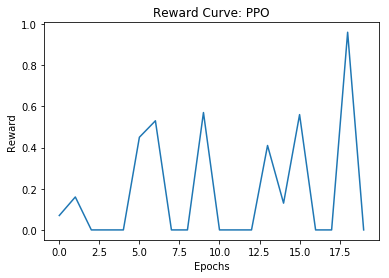

In [32]:
# plot the rewards curve
plt.plot(scores)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.title('Reward Curve: PPO')
plt.show()

In [ ]:
# uncomment this cell to load the trained policy for Pendulum-v0
# load policy
policy =  torch.load('ppo-crawler.policy',map_location='cpu')
agent = Agent(env)
agent.policy = policy

In [ ]:
frames = []
total_rewards = np.zeros(12)

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]
states = np.array(env_info.vector_observations)
value = []
r = []
for t in range(2000):
    prediction = agent.policy.act(states)
    action  = prediction['a'].cpu().numpy()
    v = prediction['v'].detach().cpu().numpy()
    #frames.append(env.render(mode='rgb_array')) 
    
    # send all actions to tne environment
    env_info = env.step(action)[brain_name]

    next_states = np.array(env_info.vector_observations)         # get next state (for each agent)
    rewards = np.array(env_info.rewards)                         # get reward (for each agent)
    terminals = np.array(env_info.local_done)                    # see if episode finished
    
    #value.append(v.squeeze())
    #r.append(reward)
    states=next_states
    total_rewards+= rewards
    
    if np.any(terminals):
        for i,terminal in enumerate(terminals):
            if terminal:
                eps_reward = total_rewards[i]
                break
        break

print ("Total reward:",eps_reward)
#animate_frames(frames)

In [14]:
a = torch.randn(3)

In [20]:
a.data.numpy()

array([-0.04466691, -0.3507598 ,  1.2199067 ], dtype=float32)